# Pengerjaan Tugas Deep Learning menggunakan TensorFlow (Week 7, Dataset ReviewTokoBaju)

File ini memuat pelatihan model Bidirectional RNN dan Deep RNN, masing-masing menggunakan TensorFlow, untuk dataset RevireTokoBaju.csv

# Persiapan: Instalasi library dan Data Preprocessing

### 1. Memastikan Instalasi library

In [1]:
# !pip install numpy matplotlib scikit-learn torch tensorflow
# %pip install numpy matplotlib scikit-learn torch tensorflow[and-cuda] keras-tuner nltk imbalanced-learn

%pip install keras-tuner imbalanced-learn

Note: you may need to restart the kernel to use updated packages.


### 2. Mengimpor Library yang Dibutuhkan

In [2]:
# Import library yang diperlukan
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Dense, Dropout, Input, BatchNormalization
from tensorflow.keras.layers import LSTM, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import keras_tuner as kt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, auc, confusion_matrix
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import json
import re
import string
import time
from copy import deepcopy

# Memeriksa apakah GPU tersedia dan dapat digunakan oleh TensorFlow
gpu_available = tf.test.is_gpu_available()
print(f"GPU available: {gpu_available}")


2025-04-25 11:14:56.340849: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-25 11:14:56.355615: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745554496.372499  213735 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745554496.377407  213735 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1745554496.392482  213735 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
GPU available: True


I0000 00:00:1745554498.800315  213735 gpu_device.cc:2019] Created device /device:GPU:0 with 2248 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1650, pci bus id: 0000:01:00.0, compute capability: 7.5


### 3. Mendefinisikan Parameter dan Pre-processing Dataset

[nltk_data] Downloading package punkt to /home/husain/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /home/husain/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /home/husain/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/husain/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Dataset shape: (23486, 11)
   Unnamed: 0  Clothing ID  Age                    Title  \
0           0          767   33                      NaN   
1           1         1080   34                      NaN   
2           2         1077   60  Some major design flaws   
3           3         1049   50         My favorite buy!   
4           4          847   47         Flattering shirt   

                                         Review Text  Rating  Recommended IND  \
0  Absolutely wonderful - silky and sexy and comf...       4                1   
1  Love this dress!  it's sooo pretty.  i happene...       5                1   
2  I had such high hopes for this dress and reall...       3                0   
3  I love, love, love this jumpsuit. it's fun, fl...       5                1   
4  This shirt is very flattering to all due to th...       5                1   

   Positive Feedback Count   Division Name Department Name Class Name  
0                        0       Initmates        Int

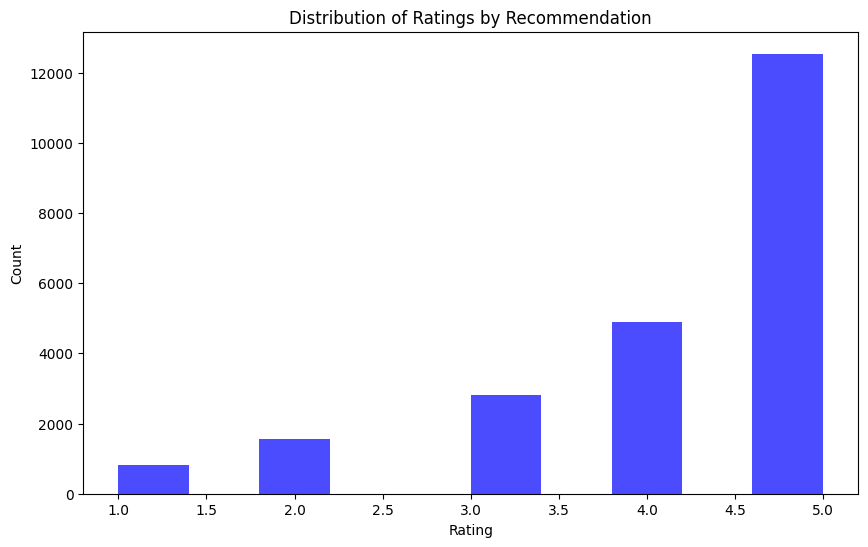

Shape of X_train: (18112,)
Shape of X_test: (4529,)


In [ ]:
# Konstanta dan parameter
NUM_WORDS = 40000
MAXLEN = 30
BATCH_SIZE = 16
EPOCHS = 25

# Download NLTK resources
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')
# Inisialisasi lemmatizer
lemmatizer = WordNetLemmatizer()
# Inisialisasi stopwords
stop_words = set(stopwords.words('english'))

# Baca dataset
df = pd.read_csv('../ReviewTokoBaju.csv')

# Eksplorasi Data
print(f"Dataset shape: {df.shape}")
print(df.head())
print(df.info())

# Text preprocessing function
def preprocess_text(text):
    # Convert to lowercase
    text = text.lower()
    
    # Menghilangkan angka
    text = re.sub(r'\d+', '', text)

    # Menghilangkan tanda baca
    text = text.translate(str.maketrans('', '', string.punctuation))
    
    # Tokenisasi
    tokens = word_tokenize(text)
    
    # Filter stopwords
    custom_stopwords = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in custom_stopwords]

    return ' '.join(tokens)

# Menggabungkan Title dan Review Text
df['Combined_Text'] = df['Title'].fillna('') + ' ' + df['Review Text']

# Memeriksa adanya null values di kolom 'Combined_Text'
print("\nChecking for null values in Combined_Text column:")
print(df['Combined_Text'].isnull().sum())

# Mengilangkan baris dengan null values di kolom 'Combined_Text'
df = df.dropna(subset=['Combined_Text'])
print("\nChecking for null values in Combined_Text column after dropping nulls:")
print(df['Combined_Text'].isnull().sum())

# Melakukan Preprocessing terhadap teks
df['Combined_Text'] = df['Combined_Text'].apply(preprocess_text)

# Memeriksa distribusi kelas target
print("\nDistribution of Recommended IND:")
print(df['Recommended IND'].value_counts())

# Memeriksa korelasi antara Rating dan Recommended IND
print("\nCorrelation between Rating and Recommended IND:")
print(df[['Rating', 'Recommended IND']].corr())

# Membuat visualisasi distribusi Rating
plt.figure(figsize=(10, 6))
plt.hist(df['Rating'], bins=10, color='blue', alpha=0.7)
plt.title('Distribution of Ratings by Recommendation')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.show()

# Memisahkan fitur dan target
X = df['Combined_Text'].values
y = df['Recommended IND'].values

# Memisahkan data menjadi data latih dan data uji
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Tokenisasi
tokenizer = Tokenizer(num_words=NUM_WORDS)
tokenizer.fit_on_texts(X_train)

# Padding
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)
X_train_pad = pad_sequences(X_train_seq, maxlen=MAXLEN)
X_test_pad = pad_sequences(X_test_seq, maxlen=MAXLEN)

print(f'Shape of X_train: {X_train.shape}')
print(f'Shape of X_test: {X_test.shape}')


train_data = (X_train_pad, y_train)
test_data = (X_test_pad, y_test)

### 4. Menyiapkan Fungsi Pelatihan Model

In [4]:
# Fungsi untuk melatih model TensorFlow
def train_model_tf(model, train_data, model_name):
    x_train, y_train = train_data
    
    # Callbacks
    callbacks = [
        EarlyStopping(
            monitor='val_loss',
            patience=5,
            restore_best_weights=True
        ),
        ModelCheckpoint(
            filepath=f'model_tensorflow_{model_name}.keras',
            monitor='val_loss',
            save_best_only=True
        )
    ]
    
    print(f"Memulai pelatihan model {model_name}...")
    start_time = time.time()
    
    # Melatih model
    history = model.fit(
        x_train, y_train,
        epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        validation_split=0.2,
        shuffle=True,
        callbacks=callbacks,
        verbose=1
    )
    
    end_time = time.time()
    training_time = end_time - start_time
    mins, secs = divmod(training_time, 60)
    print(f"Waktu pelatihan: {int(mins)}m {int(secs)}s")
    
    return history

### 5. Menyiapkan Fungsi Evaluasi

In [5]:
# Fungsi untuk evaluasi model TensorFlow
def evaluate_model_tf(model, test_data, model_name):
    x_test, y_test = test_data
    
    # Prediksi
    y_pred_prob = model.predict(x_test)
    y_pred = (y_pred_prob > 0.5).astype(int).flatten()
    
    # Menghitung metrik evaluasi
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_pred_prob)
    
    # Menghitung ROC curve
    fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
    
    # Print hasil evaluasi
    print(f"\nEvaluasi Model {model_name}:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"AUC: {auc:.4f}")
    
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'auc': auc,
        'fpr': fpr,
        'tpr': tpr,
        'y_pred_prob': y_pred_prob,
        'y_pred': y_pred,
        'y_test': y_test
    }

### 6. Menyiapkan Fungsi Visualisasi

In [6]:
# Fungsi untuk membuat visualisasi hasil
# Fungsi untuk membuat visualisasi training history
def plot_training_history(history, model_name):
    plt.figure(figsize=(12, 5))
    
    best_epoch = history['val_loss'].index(min(history['val_loss']))
    best_val_loss = min(history['val_loss'])

    # Plot Loss, dengan tanda pada titik terbaik
    plt.subplot(1, 2, 1)
    plt.plot(history['loss'], label='Train Loss')
    plt.plot(history['val_loss'], label='Valid Loss')
    plt.axvline(x=best_epoch, color='r', linestyle='--', label='Best Model')
    plt.axhline(y=best_val_loss, color='g', linestyle='--', label='Best Val Loss')
    plt.title(f'{model_name} - Loss History')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    # Plot Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history['accuracy'], label='Train Accuracy')
    plt.plot(history['val_accuracy'], label='Valid Accuracy')
    plt.axvline(x=best_epoch, color='r', linestyle='--', label='Best Model')
    plt.axhline(y=history['val_accuracy'][best_epoch], color='g', linestyle='--', label='Val Accuracy at Best Model')
    plt.title(f'{model_name} - Accuracy History')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.tight_layout()
    plt.savefig(f'training_history_tensorflow_{model_name}.png')
    plt.show()

# Fungsi untuk membuat confusion matrix
def plot_confusion_matrix(y_true, y_pred, model_name):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(f'{model_name} - Confusion Matrix')
    plt.colorbar()
    tick_marks = np.arange(2)
    plt.xticks(tick_marks, ['Negative', 'Positive'])
    plt.yticks(tick_marks, ['Negative', 'Positive'])
    
    thresh = cm.max() / 2.
    for i, j in np.ndindex(cm.shape):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.savefig(f'confusion_matrix_tensorflow_{model_name}.png')
    plt.show()

# Fungsi untuk membuat ROC curve
def plot_roc_curve(results_dict):
    plt.figure(figsize=(10, 8))
    
    for model_name, result in results_dict.items():
        plt.plot(result['fpr'], result['tpr'], label=f'{model_name} (AUC = {result["auc"]:.4f})')
    
    plt.plot([0, 1], [0, 1], 'k--', label='Random')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve Comparison')
    plt.legend()
    plt.grid(True)
    plt.savefig('roc_curve_comparison_tensorflow.png')
    plt.show()

# Fungsi untuk membuat bar chart perbandingan metrik
def plot_metrics_comparison(results_dict):
    metrics = ['accuracy', 'precision', 'recall', 'f1', 'auc']
    models = list(results_dict.keys())
    
    values = {metric: [results_dict[model][metric] for model in models] for metric in metrics}
    
    plt.figure(figsize=(12, 8))
    bar_width = 0.15
    index = np.arange(len(models))
    
    for i, metric in enumerate(metrics):
        plt.bar(index + i * bar_width, values[metric], bar_width, 
                label=metric.capitalize())
    
    plt.xlabel('Models')
    plt.ylabel('Scores')
    plt.title('Performance Metrics Comparison')
    plt.xticks(index + bar_width * 2, models)
    plt.legend()
    plt.grid(True, axis='y')
    plt.savefig('metrics_comparison_tensorflow.png')
    plt.show()


## A. Model Bidirectional RNN Menggunakan TensorFlow

### 1. Menyusun Model Bidirectional RNN


In [7]:
# Fungsi untuk membuat model RNN bidireksional kompleks dengan LSTM
def build_birnn_model(embedding_dim=128, lstm_units=64, dropout_rate=0.2, recurrent_dropout=0.2, dense_units=32, learning_rate=0.001):
    model = Sequential([
        Input(shape=(MAXLEN,)),
        Embedding(NUM_WORDS, embedding_dim),
        
        Bidirectional(LSTM(lstm_units, return_sequences=True, dropout=dropout_rate)),
        BatchNormalization(),
        Bidirectional(LSTM(lstm_units, return_sequences=False, dropout=dropout_rate)),
        BatchNormalization(),
        Dense(dense_units, activation='relu'),
        Dropout(dropout_rate),
        Dense(1, activation='sigmoid')
    ])
    
    # Menyusun model
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='binary_crossentropy', metrics=['accuracy'])
    
    # Menampilkan ringkasan model
    print(model.summary())

    return model

# inisialisasi model
model_birnn = build_birnn_model()

I0000 00:00:1745554502.882725  213735 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 2248 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1650, pci bus id: 0000:01:00.0, compute capability: 7.5


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 30, 128)        │     5,120,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 30, 128)        │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 30, 128)        │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 128)            │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,322,817 (20.30 MB)

 Trainable params: 5,322,305 (20.30 MB)

 Non-trainable params: 512 (2.00 KB)

None


### 2. Melatih Model dan Hyperparameter Tuning

In [8]:
# Melatih model RNN awal
print("Melatih model RNN...")
history_birnn = train_model_tf(model_birnn, (X_train_pad, y_train), 'birnn')

# Menggunakan hyperparameter tuning untuk mengoptimalkan model
# Fungsi untuk membuat model dengan hyperparameter tuning
def build_hptune_birnn_model(hp):
    # Hyperparameter yang akan dituning   
    embedding_dim = hp.Int('embedding_dim', min_value=64, max_value=256, step=32)
    lstm_units = hp.Int('lstm_units', min_value=32, max_value=128, step=32)
    dropout_rate = hp.Float('dropout_rate', min_value=0.1, max_value=0.5, step=0.1)
    recurrent_dropout = hp.Float('recurrent_dropout', min_value=0.0, max_value=0.3, step=0.1)
    learning_rate = hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='log')
    dense_units = hp.Int('dense_units', min_value=32, max_value=128, step=32)
    
    model = build_birnn_model(
        embedding_dim=embedding_dim,
        lstm_units=lstm_units,
        dropout_rate=dropout_rate,
        recurrent_dropout=recurrent_dropout,
        dense_units=dense_units,
        learning_rate=learning_rate
    )
    
    return model

# Inisialisasi hyperparameter tuner
tuner_birnn = kt.Hyperband(
    build_hptune_birnn_model,
    objective='val_accuracy',
    max_epochs=5,
    factor=3,
    directory='tuning_results',
    project_name='tuning_birnn',
)

# Menjalankan hyperparameter tuning
tuner_birnn.search(X_train_pad, y_train, epochs=3, batch_size=BATCH_SIZE, validation_split=0.2,
             shuffle=True,
             callbacks=[EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)],
             verbose=1
)

# Menampilkan hasil hyperparameter tuning
best_hps_birnn = tuner_birnn.get_best_hyperparameters(num_trials=1)[0]
print(f"Best Hyperparameters:")
print(f"Embedding dimension: {best_hps_birnn.get('embedding_dim')}")
print(f"LSTM units: {best_hps_birnn.get('lstm_units')}")
print(f"Dropout rate: {best_hps_birnn.get('dropout_rate')}")
print(f"Recurrent dropout rate: {best_hps_birnn.get('recurrent_dropout')}")
print(f"Learning rate: {best_hps_birnn.get('learning_rate')}")
print(f"Dense units: {best_hps_birnn.get('dense_units')}")

# Membangun model dengan hyperparameter terbaik
model_birnn = tuner_birnn.hypermodel.build(best_hps_birnn)

# Melatih model dengan hyperparameter terbaik
print("Melatih model dengan hyperparameter terbaik...")
history_birnn = train_model_tf(model_birnn, (X_train_pad, y_train), 'birnn')

Trial 10 Complete [00h 03m 08s]
val_accuracy: 0.8733094334602356

Best val_accuracy So Far: 0.8780016303062439
Total elapsed time: 00h 20m 53s
Best Hyperparameters:
Embedding dimension: 192
LSTM units: 32
Dropout rate: 0.2
Recurrent dropout rate: 0.2
Learning rate: 0.0005813630132783719
Dense units: 96


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ (None, 30, 192)        │     7,680,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_2 (Bidirectional) │ (None, 30, 64)         │        57,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 30, 64)         │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_3 (Bidirectional) │ (None, 64)             │        24,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 96)             │         6,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 96)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            97 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,769,281 (29.64 MB)

 Trainable params: 7,769,025 (29.64 MB)

 Non-trainable params: 256 (1.00 KB)

None
Melatih model dengan hyperparameter terbaik...
Memulai pelatihan model birnn...
Epoch 1/25
906/906 ━━━━━━━━━━━━━━━━━━━━ 54s 57ms/step - accuracy: 0.8046 - loss: 0.4202 - val_accuracy: 0.8705 - val_loss: 0.2900
Epoch 2/25
906/906 ━━━━━━━━━━━━━━━━━━━━ 46s 50ms/step - accuracy: 0.9151 - loss: 0.2105 - val_accuracy: 0.8570 - val_loss: 0.3091
Epoch 3/25
906/906 ━━━━━━━━━━━━━━━━━━━━ 44s 48ms/step - accuracy: 0.9395 - loss: 0.1555 - val_accuracy: 0.8761 - val_loss: 0.3533
Epoch 4/25
906/906 ━━━━━━━━━━━━━━━━━━━━ 46s 50ms/step - accuracy: 0.9574 - loss: 0.1090 - val_accuracy: 0.8705 - val_loss: 0.4498
Epoch 5/25
906/906 ━━━━━━━━━━━━━━━━━━━━ 46s 51ms/step - accuracy: 0.9708 - loss: 0.0806 - val_accuracy: 0.8703 - val_loss: 0.4586
Epoch 6/25
906/906 ━━━━━━━━━━━━━━━━━━━━ 43s 47ms/step - accuracy: 0.9780 - loss: 0.0590 - val_accuracy: 0.8714 - val_loss: 0.5170
Waktu pelatihan: 4m 38s


### 3. Mengevaluasi Model dengan Menghitung Akurasi, Presisi, Recall, F1Squared, ROC, dan AUC-ROC

In [9]:
# Evaluasi model RNN
result_birnn = evaluate_model_tf(model_birnn, test_data, 'birnn')

 62/142 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step

142/142 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step

Evaluasi Model birnn:
Accuracy: 0.8889
Precision: 0.9131
Recall: 0.9556
F1 Score: 0.9339
AUC: 0.9221


### 4. Memvisualisasikan Prediksi dari model yang telah dilatih

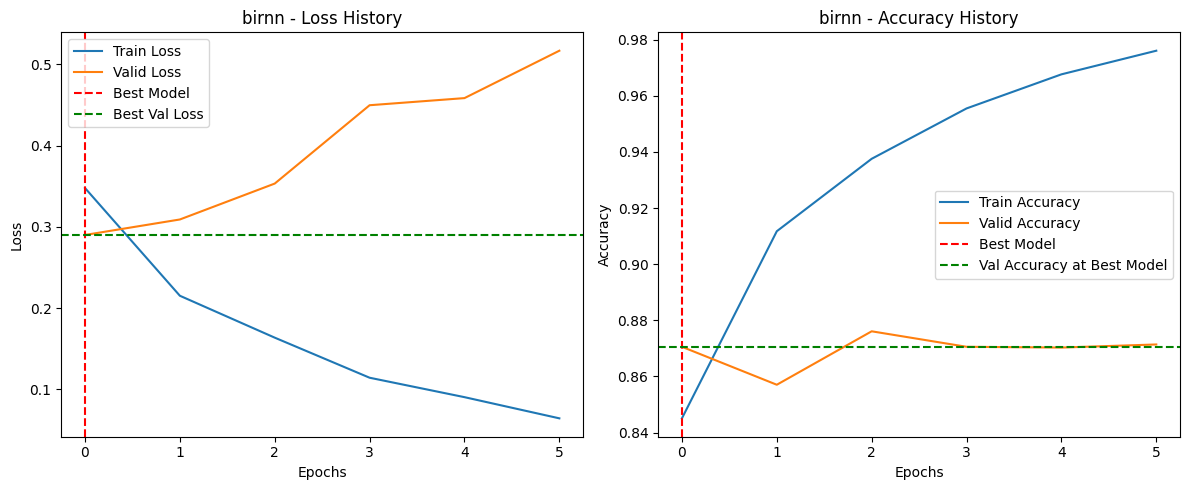

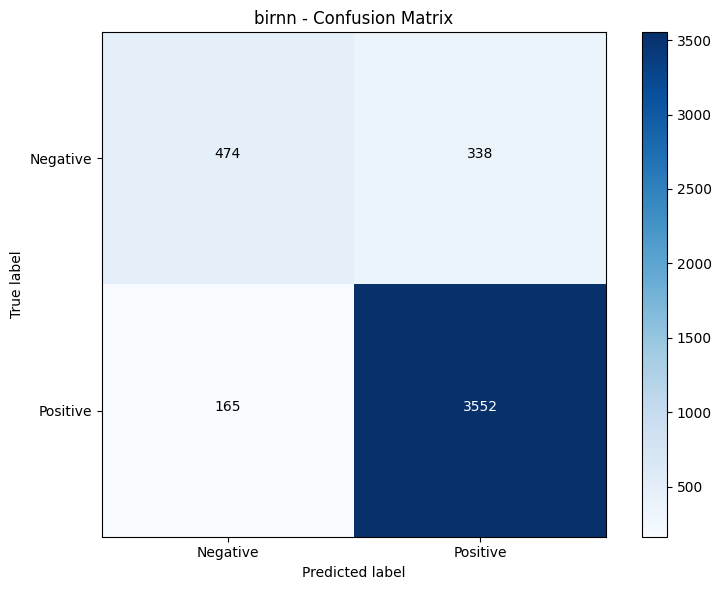

In [10]:
# Plotting hasil pelatihan
plot_training_history(history_birnn.history, "birnn")

# Plotting confusion matrix
plot_confusion_matrix(y_test, result_birnn['y_pred'], "birnn")

### 5. Menyimpan Model

In [11]:
# Menyimpan model
model_birnn.save('model_tensorflow_birnn.keras')
print("Model RNN disimpan sebagai 'model_tensorflow_birnn.keras'")

Model RNN disimpan sebagai 'model_tensorflow_birnn.keras'


## B. Model Deep RNN Menggunakan TensorFlow

### 1. Menyusun Model Deep RNN


In [20]:
# Fungsi untuk membuat model Deep RNN kompleks dengan LSTM
def build_drnn_model(embedding_dim=128, lstm_units=64, dropout_rate=0.2, recurrent_dropout=0.2, dense_units=64, learning_rate=0.001):
    model = Sequential([
        Input(shape=(MAXLEN,)),
        Embedding(NUM_WORDS, embedding_dim),
        
        LSTM(lstm_units, return_sequences=True, dropout=dropout_rate),
        BatchNormalization(),
        LSTM(lstm_units, return_sequences=True, dropout=dropout_rate),
        BatchNormalization(),
        LSTM(lstm_units, return_sequences=True, dropout=dropout_rate),
        BatchNormalization(),
        LSTM(lstm_units, return_sequences=True, dropout=dropout_rate),
        BatchNormalization(),
        LSTM(lstm_units, return_sequences=False, dropout=dropout_rate),
        BatchNormalization(),
        
        Dense(dense_units, activation='relu'),
        Dropout(dropout_rate),
        Dense(dense_units // 2, activation='relu'),
        Dropout(dropout_rate),
        Dense(dense_units // 4, activation='relu'),
        Dropout(dropout_rate),
        Dense(1, activation='sigmoid')
    ])

    # Menyusun model
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

# inisialisasi model
model_drnn = build_drnn_model()

### 2. Melatih Model dan Hyperparameter Tuning

In [21]:
# Melatih model RNN awal
print("Melatih model RNN...")
history_drnn = train_model_tf(model_drnn, (X_train_pad, y_train), 'drnn')

# Fungsi untuk membuat model dengan hyperparameter tuning
def build_hptune_drnn_model(hp):
    # Hyperparameters to tune
    embedding_dim = hp.Int('embedding_dim', min_value=64, max_value=256, step=32)
    lstm_units = hp.Int('lstm_units', min_value=32, max_value=128, step=32)
    dropout_rate = hp.Float('dropout_rate', min_value=0.1, max_value=0.5, step=0.1)
    recurrent_dropout = hp.Float('recurrent_dropout', min_value=0.0, max_value=0.3, step=0.1)
    learning_rate = hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='log')
    dense_units = hp.Int('dense_units', min_value=32, max_value=128, step=32)
    
    model = build_drnn_model(
        embedding_dim=embedding_dim,
        lstm_units=lstm_units,
        dropout_rate=dropout_rate,
        recurrent_dropout=recurrent_dropout,
        dense_units=dense_units,
        learning_rate=learning_rate
    )
    
    return model

# Inisialisasi hyperparameter tuner
tuner_drnn = kt.Hyperband(
    build_hptune_drnn_model,
    objective='val_accuracy',
    max_epochs=5,
    factor=3,
    directory='tuning_results',
    project_name='tuning_drnn'
)

# Menjalankan hyperparameter tuning
tuner_drnn.search(X_train_pad, y_train, epochs=5, batch_size=BATCH_SIZE, validation_split=0.2,
             shuffle=True,
             callbacks=[EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)],
             verbose=1
)

# Menampilkan hasil hyperparameter tuning
best_hps_drnn = tuner_drnn.get_best_hyperparameters(num_trials=1)[0]
print(f"Best Hyperparameters:")
print(f"Embedding dimension: {best_hps_drnn.get('embedding_dim')}")
print(f"LSTM units: {best_hps_drnn.get('lstm_units')}")
print(f"Dropout rate: {best_hps_drnn.get('dropout_rate')}")
print(f"Recurrent dropout rate: {best_hps_drnn.get('recurrent_dropout')}")
print(f"Learning rate: {best_hps_drnn.get('learning_rate')}")
print(f"Dense units: {best_hps_drnn.get('dense_units')}")

# Membangun model dengan hyperparameter terbaik
model_drnn = tuner_drnn.hypermodel.build(best_hps_drnn)

# Melatih model dengan hyperparameter terbaik
print("Melatih model dengan hyperparameter terbaik...")
history_drnn = train_model_tf(model_drnn, (X_train_pad, y_train), 'drnn')

Trial 10 Complete [00h 05m 14s]
val_accuracy: 0.8619928359985352

Best val_accuracy So Far: 0.877449631690979
Total elapsed time: 00h 32m 15s
Best Hyperparameters:
Embedding dimension: 160
LSTM units: 128
Dropout rate: 0.2
Recurrent dropout rate: 0.1
Learning rate: 0.0007754815202783544
Dense units: 128
Melatih model dengan hyperparameter terbaik...
Memulai pelatihan model drnn...
Epoch 1/25
906/906 ━━━━━━━━━━━━━━━━━━━━ 66s 69ms/step - accuracy: 0.7752 - loss: 0.5218 - val_accuracy: 0.8457 - val_loss: 0.3508
Epoch 2/25
906/906 ━━━━━━━━━━━━━━━━━━━━ 62s 69ms/step - accuracy: 0.8559 - loss: 0.3218 - val_accuracy: 0.8634 - val_loss: 0.3249
Epoch 3/25
906/906 ━━━━━━━━━━━━━━━━━━━━ 67s 74ms/step - accuracy: 0.8985 - loss: 0.2610 - val_accuracy: 0.8639 - val_loss: 0.3126
Epoch 4/25
906/906 ━━━━━━━━━━━━━━━━━━━━ 60s 66ms/step - accuracy: 0.9189 - loss: 0.2124 - val_accuracy: 0.8728 - val_loss: 0.3229
Epoch 5/25
906/906 ━━━━━━━━━━━━━━━━━━━━ 63s 70ms/step - accuracy: 0.9402 - loss: 0.1756 - val_ac

### 3. Mengevaluasi Model dengan Menghitung Akurasi, Presisi, Recall, F1Squared, ROC, dan AUC-ROC

In [22]:
# Evaluasi model RNN
result_drnn = evaluate_model_tf(model_drnn, test_data, 'drnn')

142/142 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step

Evaluasi Model drnn:
Accuracy: 0.8801
Precision: 0.9237
Recall: 0.9309
F1 Score: 0.9272
AUC: 0.9059


### 4. Memvisualisasikan Prediksi dari model yang telah dilatih

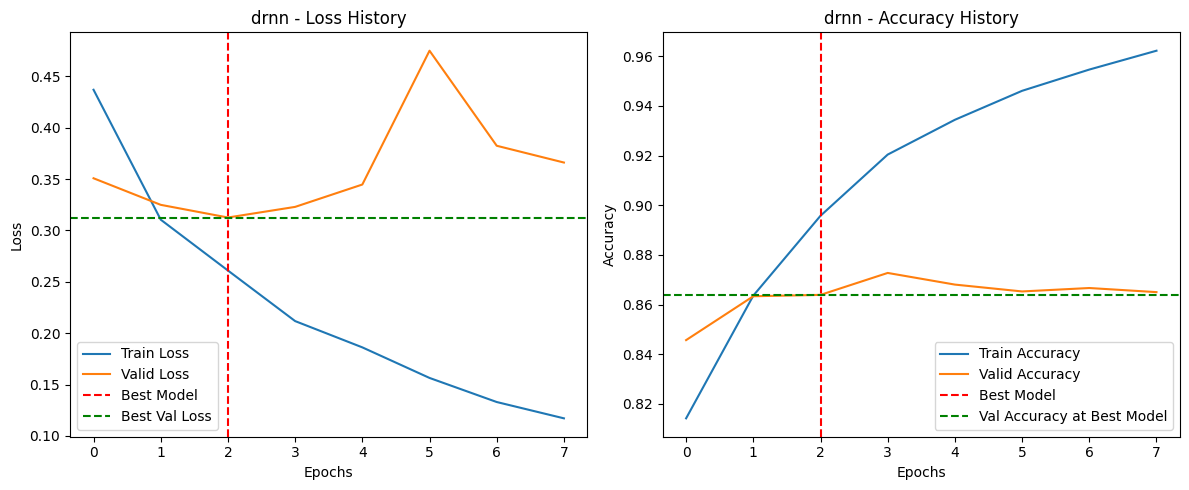

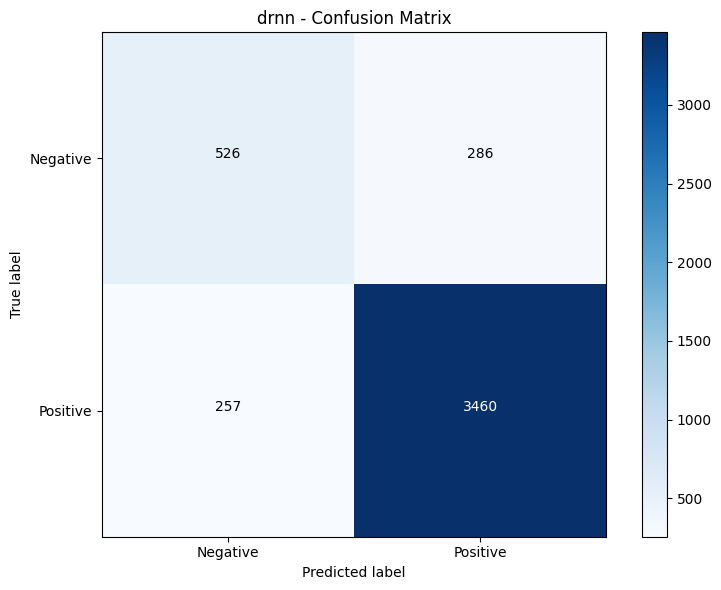

In [23]:
# Plotting hasil pelatihan
plot_training_history(history_drnn.history, "drnn")

# Plotting confusion matrix
plot_confusion_matrix(y_test, result_drnn['y_pred'], "drnn")

### 5. Menyimpan Model

In [24]:
# Menyimpan model
model_drnn.save('model_tensorflow_drnn.keras')
print("Model RNN disimpan sebagai 'model_tensorflow_drnn.keras'")

Model RNN disimpan sebagai 'model_tensorflow_drnn.keras'


# Perbandingan antara model

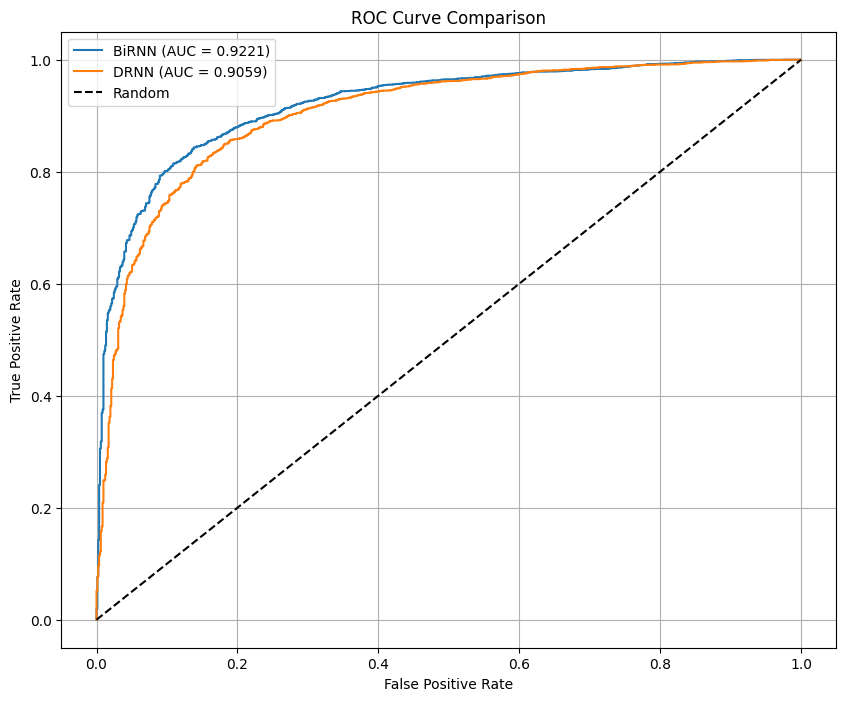

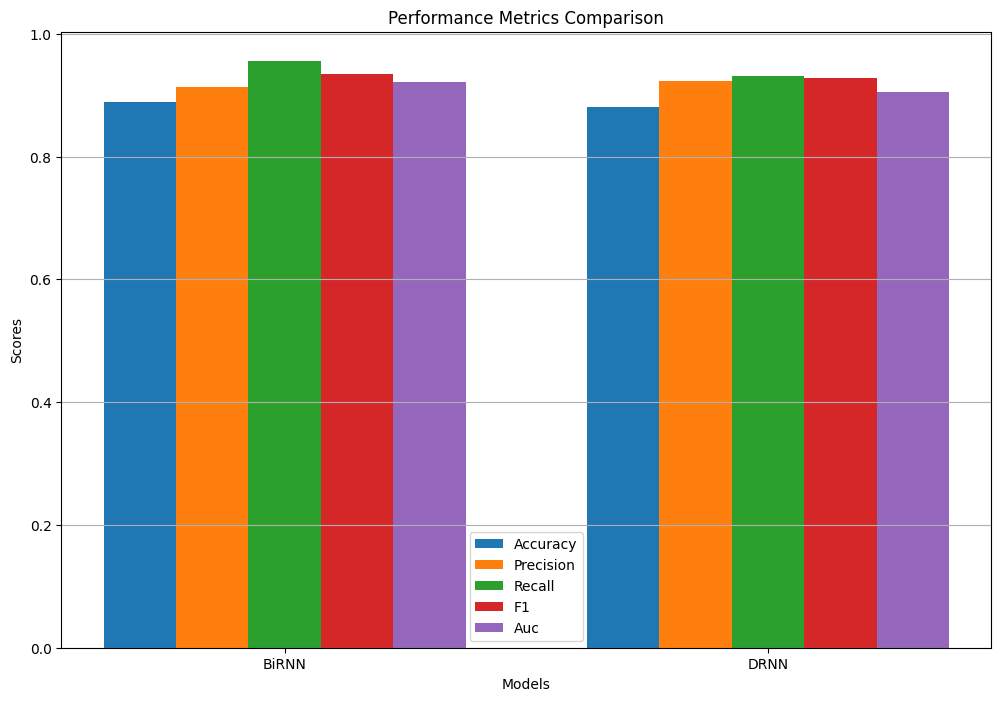

In [25]:
# Menghitung perbandingan untuk semua model
results_dict = {
    'BiRNN': result_birnn,
    'DRNN': result_drnn,
}

# Plotting ROC curve
plot_roc_curve(results_dict)
# Plotting perbandingan metrik
plot_metrics_comparison(results_dict)